__Purpose:__ Before implementing Federated Learning, re-implement the original simulatinos on the continuous data task we've been working off of to ensure that we implement the correct loss functions in the federated learning task. Simulated decoders should match the decoders found in Ws_block1 from the CPHS data pickle file.
<br>
1. The dec matrix is the weights to pass back and forth, although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.  I think.

In [6]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize, least_squares
import copy
from itertools import permutations

In [7]:
from experiment_params import *
from cost_funcs import *
import time
import pickle

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [8]:
t0 = time.time()

full_data_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Data\\continuous_full_data_block1.pickle'
with open(full_data_path, 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\continuous_full_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    #refs_block2, _, _, _, emgs_block2, Ws_block2, _, _, _, _, _ = pickle.load(handle)

t1 = time.time()
total = t1-t0  
print(total)

6.625762939453125


In [9]:
# 8 conditions, 20770 data points (only 19 unique sets!), xy, channels
Ws_block1[keys[0]].shape

(8, 20770, 2, 64)

In [10]:
update_ix

array([    0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614,
       10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432,
       20769])

In [11]:
dec_cond0_user1_update0 = Ws_block1[keys[0]][0,0,:,:]
dec_cond0_user1_update1 = Ws_block1[keys[0]][0,update_ix[1],:,:]
dec_cond0_user1_update2 = Ws_block1[keys[0]][0,update_ix[2],:,:]

print(f"Shape of decoder: {dec_cond0_user1_update0.shape}")
print()
print(f"Total difference between dec0 and dec1: {(dec_cond0_user1_update0 - dec_cond0_user1_update1).sum()}")
print("E.g., as previously shown, the first two decs are the same")
print()
print(f"Total difference between dec0 and dec2: {(dec_cond0_user1_update0 - dec_cond0_user1_update2).sum()}")

Shape of decoder: (2, 64)

Total difference between dec0 and dec1: 0.0
E.g., as previously shown, the first two decs are the same

Total difference between dec0 and dec2: 3.1981579823181594


In [12]:
#emg_cond0_user1_update0 = emg_data_df.iloc[:64,:].shape

# (Condition, datapoints, channels)
print(emgs_block1[keys[0]][:,:,:].shape)

# Condition 0 of subject 1 ("0")
print(emgs_block1[keys[0]][0,:,:].shape)

(8, 20770, 64)
(20770, 64)


## Run One Iteration On Above Data and Check Decoders Are the Same
1. Modifying Simulations Code

In [13]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
# Assuming these are the same as lambda's, the decoder cost penalties
alphaD = 1e-3
#where is lambda E?

# Setting alphaF to 0 to allow us to directly compare cost funcs
#alphaF = 1e-7
alphaF = 0

Condition 0 only for now

In [14]:
num_updates=19
for ix in range(num_updates-1):
    print((ix, ix+1))

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 14)
(14, 15)
(15, 16)
(16, 17)
(17, 18)


In [15]:
num_updates=19
for ix in range(num_updates-3):
    print((ix, ix+1))

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
(5, 6)
(6, 7)
(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 14)
(14, 15)
(15, 16)


In [32]:
first_half = 14  # Used to be 7, idk why I only wanted to use half

#def simulation(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2,display_info=False,num_iters=False):
display_info=False
total_num_updates = 19
final_training_update = 15
starting_update = 0 # This is not used anywhere else except directly below FYI 
num_updates = final_training_update - starting_update
dt = 1/60

D = [[0 for _ in range(num_updates)] for i in range(first_half)]
cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
grad_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
performance_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
Dnorm_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
#Fnorm_log = [[0 for _ in range(num_updates)] for i in range(first_half)]

test_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
test_cost_log_postSB = [[0 for _ in range(num_updates)] for i in range(first_half)]
s_test_log = [0]*first_half
F_test_log = [0]*first_half
p_test_reference_log = [0]*first_half

# All clients share the same bounds
test_lower_bound = (update_ix[final_training_update+1])#//2  #Use only the second half of each update
test_upper_bound = update_ix[final_training_update+2]
test_learning_batch = test_upper_bound - test_lower_bound

for idx, user in enumerate(keys[:first_half]):
    filtered_signals = emgs_block1[user][0,:,:]
    p_reference_full = refs_block1[user][0,:,:]
    D[idx][0] = Ws_block1[user][0,0,:,:]
    total_datapoints = emgs_block1[user][0,:,:].shape[0]
    
    # TESTING LOG
    # Each client will have their own testing data (only needs to be set once)
    s_test_log[idx] = np.transpose(filtered_signals[test_lower_bound:test_upper_bound,:])
    F_test_log[idx] = s_test_log[idx][:,:-1] # note: truncate F for estimate_decoder
    p_test_reference_log[idx] = np.transpose(p_reference_full[test_lower_bound:test_upper_bound,:])

    # batches the trials into each of the update batch
    # Do num_updates-1 because the very last update is only 1 datapoint, the 2nd to last is only 337
    for ix in range(final_training_update-1):
        ix+=1  # I think this might make it skip the 1st update (eg update 0) --> I changed it to ix-1, ix
        # Reason is because it lets us do D[idx][ix-1] to get the init dec
        #print(ix)

        # Instead of using learning_batch, we should get the same results just using update_ix values
        if ix==(final_training_update):
            upper_bound = total_datapoints
        else:
            upper_bound = update_ix[ix]
        #lower_bound = (upper_bound-update_ix[ix-1])//2
        #^This is what it ought to be but signal blows up for some reason
        lower_bound = update_ix[ix-1]
        learning_batch = upper_bound - lower_bound

        s = np.transpose(filtered_signals[lower_bound:upper_bound,:])
        v_actual = D[idx][ix-1]@s
        # Numerical integration of v_actual to get p_actual
        p_actual = np.cumsum(v_actual, axis=1)*dt
        # Update decoder
        p_reference = np.transpose(p_reference_full[lower_bound:upper_bound,:])
        #(r-y)/60=D_new@s  # This is the optimization problem
        V = (p_reference - p_actual)*dt
        F = copy.deepcopy(s[:,:-1]) # note: truncate F for estimate_decoder

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        # Is using D[-1] the same as solving the lambda min D function?
        cost_log[idx][ix] = cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        grad_cost_log[idx][ix] = gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})

        performance_log[idx][ix] = (1e-6)*(np.linalg.norm((D[idx][ix-1]@F + H@V[:,:-1] - V[:,1:]))**2)
        Dnorm_log[idx][ix] = alphaD*(np.linalg.norm(D[idx][ix-1])**2)
        
        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))
        
        # TESTING LOG
        model = W_hat
        v_actual = model@s_test_log[idx]
        p_actual = np.cumsum(v_actual, axis=1)*dt  # Numerical integration of v_actual to get p_actual
        V_test = (p_test_reference_log[idx] - p_actual)*dt
        test_cost_log[idx][ix] = cost_l2(F_test_log[idx],model,H,V_test,test_learning_batch,alphaF,alphaD)

        # DO SMOOTHBATCH
        W_new = alpha*D[idx][ix-1] + ((1 - alpha) * W_hat)
        D[idx][ix] = W_new

        model = D[idx][ix]
        v_actual = model@s_test_log[idx]
        p_actual = np.cumsum(v_actual, axis=1)*dt  # Numerical integration of v_actual to get p_actual
        V_test = (p_test_reference_log[idx] - p_actual)*dt
        test_cost_log_postSB[idx][ix] = cost_l2(F_test_log[idx],model,H,V_test,test_learning_batch,alphaF,alphaD)

C:\Users\kdmen\AppData\Local\Temp\ipykernel_23220\3618409499.py:74: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})


In [33]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

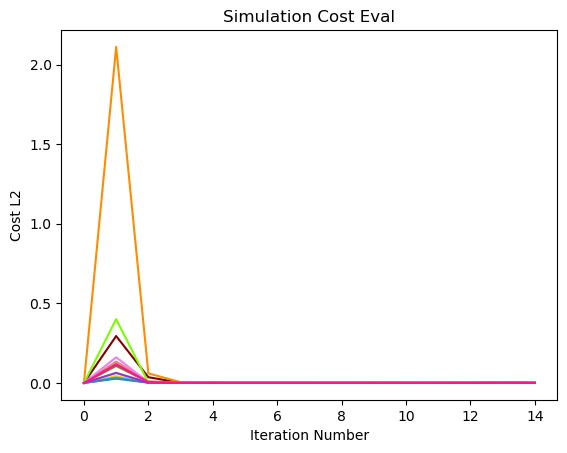

In [35]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
#plt.ylim(0, 70)
plt.show()

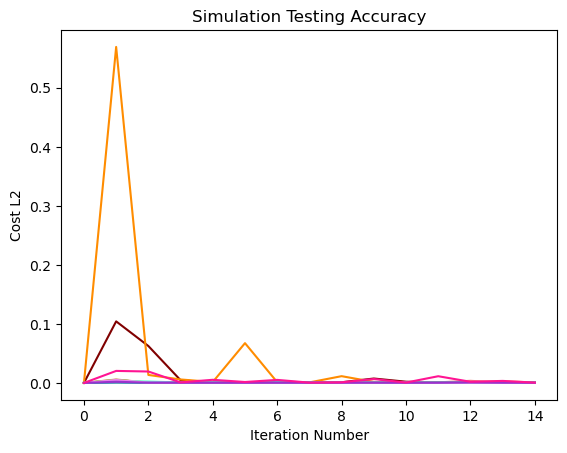

In [39]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, test_cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Testing Accuracy')
#plt.ylim(0, 70)
plt.show()

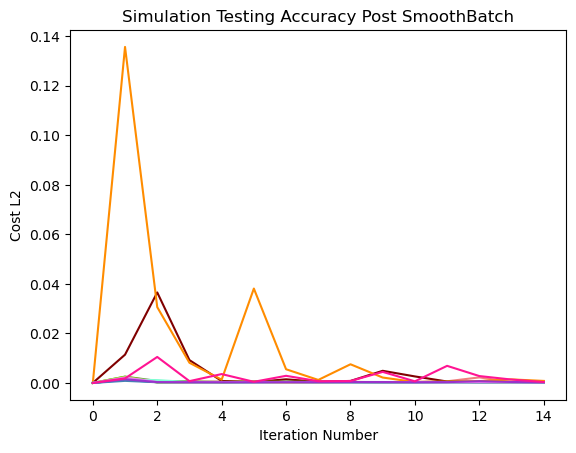

In [40]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, test_cost_log_postSB[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Testing Accuracy Post SmoothBatch')
#plt.ylim(0, 70)
plt.show()

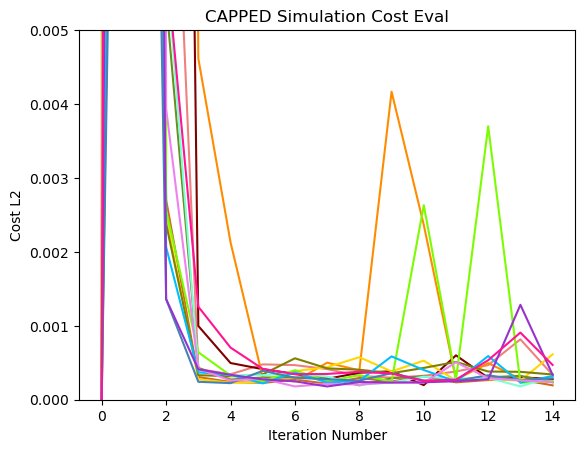

In [36]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED Simulation Cost Eval')
plt.ylim(0, 0.005)
plt.show()

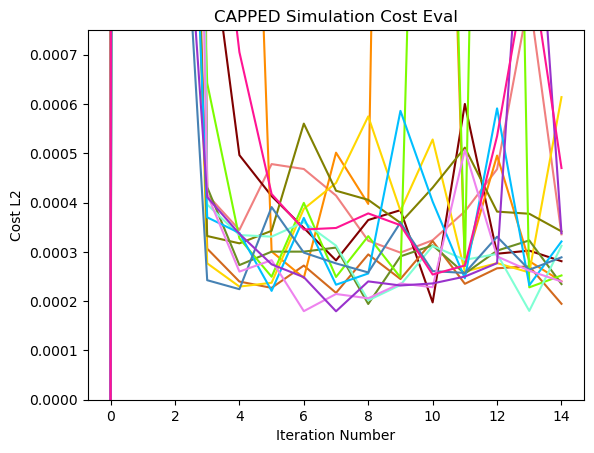

In [37]:
step_indices = list(range(num_updates))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED Simulation Cost Eval')
plt.ylim(0, 0.00075)
plt.show()

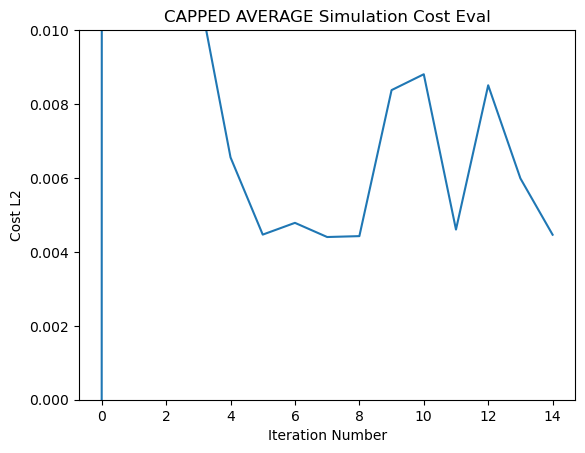

In [38]:
step_indices = list(range(num_updates))
avg_cost_npy = np.zeros(num_updates)
for i in range(first_half):
    avg_cost_npy += np.array(cost_log[i])
plt.plot(step_indices, avg_cost_npy)
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost Eval')
plt.ylim(0, 0.01)
plt.show()

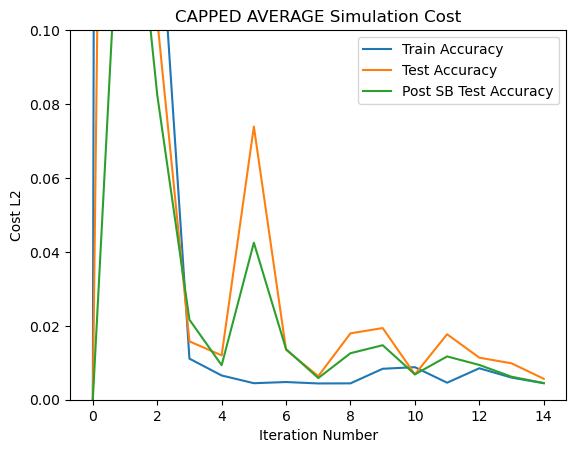

In [44]:
step_indices = list(range(num_updates))
avg_train_cost_npy = np.zeros(num_updates)
avg_test_cost_npy = np.zeros(num_updates)
avg_testSB_cost_npy = np.zeros(num_updates)
for i in range(first_half):
    avg_train_cost_npy += np.array(cost_log[i])
    avg_test_cost_npy += np.array(test_cost_log[i])
    avg_testSB_cost_npy += np.array(test_cost_log_postSB[i])
plt.plot(step_indices, avg_cost_npy, label="Train Accuracy")
plt.plot(step_indices, avg_test_cost_npy, label="Test Accuracy")
plt.plot(step_indices, avg_testSB_cost_npy, label="Post SB Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

In [21]:
assert(1==0)

AssertionError: 

# Save Output Data For Plotting In Another NB

In [47]:
avg_train_cost_df = pd.DataFrame(avg_train_cost_npy)
avg_test_cost_df = pd.DataFrame(avg_test_cost_npy)
avg_testSB_cost_df = pd.DataFrame(avg_testSB_cost_npy)

print(avg_train_cost_df.shape)

(15, 1)


In [46]:
cost_df = pd.DataFrame(cost_log)
test_cost_df = pd.DataFrame(test_cost_log)
test_cost_df_postSB = pd.DataFrame(test_cost_log_postSB)

print(cost_df.shape)

(14, 15)


In [49]:
new_row = avg_train_cost_df.iloc[:].transpose()
cost_df = pd.concat([cost_df, new_row], ignore_index=True)
print("COST DF")
print(cost_df.shape)
cost_df.head()

COST DF
(15, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.134106,0.010481,0.000416,0.000345,0.000478,0.000468,0.000414,0.000323,0.000298,0.000324,0.000382,0.000468,0.000817,0.000336
1,0.0,0.294417,0.035896,0.000997,0.000496,0.000413,0.000349,0.000283,0.000365,0.000385,0.000197,0.000600,0.000296,0.000303,0.000281
2,0.0,0.030525,0.002704,0.000307,0.000240,0.000227,0.000272,0.000217,0.000295,0.000245,0.000322,0.000235,0.000267,0.000271,0.000195
3,0.0,2.110621,0.060204,0.004617,0.002130,0.000301,0.000247,0.000501,0.000397,0.004167,0.002366,0.000272,0.000495,0.000281,0.000240
4,0.0,0.043069,0.002469,0.000277,0.000230,0.000237,0.000387,0.000440,0.000575,0.000383,0.000528,0.000260,0.000277,0.000258,0.000614


In [50]:
new_row = avg_test_cost_df.iloc[:].transpose()
test_cost_df = pd.concat([test_cost_df, new_row], ignore_index=True)
print("TEST COST DF")
print(test_cost_df.shape)
test_cost_df.head()

TEST COST DF
(15, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.005821,0.000453,0.000297,0.000870,0.000317,0.000617,0.000374,0.000507,0.000371,0.000492,0.000962,0.003563,0.000358,0.000372
1,0.0,0.104268,0.062535,0.004593,0.000524,0.000482,0.002301,0.000999,0.001129,0.007457,0.002071,0.000732,0.000344,0.000406,0.000778
2,0.0,0.000732,0.000462,0.000275,0.000349,0.000360,0.000240,0.000229,0.000320,0.000268,0.000268,0.000222,0.000265,0.000213,0.000208
3,0.0,0.569192,0.013515,0.005858,0.001604,0.067395,0.001330,0.000895,0.011433,0.001695,0.000332,0.000974,0.001446,0.002466,0.000968
4,0.0,0.002051,0.000443,0.000514,0.000383,0.000554,0.000298,0.000469,0.000586,0.000297,0.000373,0.000460,0.000354,0.000361,0.000344


In [51]:
new_row = avg_testSB_cost_df.iloc[:].transpose()
test_cost_df_postSB = pd.concat([test_cost_df_postSB, new_row], ignore_index=True)
print("TEST SB COST DF")
print(test_cost_df_postSB.shape)
test_cost_df_postSB.head()

TEST SB COST DF
(15, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.001746,0.000343,0.000268,0.000609,0.000309,0.000508,0.000351,0.000381,0.000353,0.000401,0.000657,0.002228,0.000312,0.000263
1,0.0,0.011414,0.036537,0.009217,0.000794,0.000338,0.001460,0.000456,0.000798,0.004891,0.002623,0.000568,0.000287,0.000334,0.000563
2,0.0,0.001801,0.000241,0.000226,0.000264,0.000297,0.000230,0.000212,0.000257,0.000238,0.000234,0.000205,0.000213,0.000181,0.000173
3,0.0,0.135675,0.030610,0.008135,0.001317,0.038107,0.005517,0.001209,0.007529,0.002173,0.000375,0.000532,0.000740,0.001423,0.000807
4,0.0,0.001385,0.000276,0.000382,0.000333,0.000386,0.000269,0.000369,0.000423,0.000259,0.000292,0.000376,0.000321,0.000322,0.000291


In [52]:
cost_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_train_cost_df.csv")
test_cost_df.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df.csv")
test_cost_df_postSB.to_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df_postSB.csv")